In [1]:
# Importing the necessary packages
import numpy as np
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import least_squares
d = 'Downloads/'

In [2]:
def bias_subtract(data):

    '''
    PURPOSE:
            Subtract the overscan region from the data

    INPUTS:
               [data; np.array, float]:  The data to be bias subtracted

    OUTPUTS:
            [new_data; np.array, float]:  The bias subtracted data
    '''

    # Create a new array to hold the bias subtracted data
    new_data = np.empty(data.shape)

    # Loop over each column and subtract the median of the overscan region
    for i in range(data.shape[1]):

        # Get the overscan region for this column
        overscan_data = data[-16:, i]

        # Calculate the median of the overscan region
        overscan_median = np.median(overscan_data)

        # Subtract the median from the data
        new_data[:, i] = data[:, i] - overscan_median 

    return new_data

# Compute Master Flat

In [3]:
# Define the filter
filter = 'B'

# Get the list of files
files = glob.glob(d + 'flats/*' + filter + '*')

# Open the first file
file = fits.open(files[0])

# Get the data and header
data = file[0].data
header = file[0].header

# Get the image size
imsize_y, imsize_x = data.shape

# Create a data cube to hold all the data
n = len(files)
data_cube = np.zeros((imsize_y, imsize_x, n)) 

# Loop over all the files
for i in range(len(files)):

    # Open the file
    file = fits.open(files[i])

    # Get the data and header
    data = file[0].data
    header = file[0].header

    # Bias subtract the data
    new_data = bias_subtract(data)

    # Normalize the data
    new_data_normalized = new_data/np.nanmedian(new_data)

    # Add the data to the data cube
    data_cube[:,:,i] = new_data_normalized

# Calculate the master flat
master_flat = np.median(data_cube, axis = 2)

# Write the master flat to a file
fits.writeto('master_flat_' + filter + '.fits', master_flat, header = None, overwrite = True)

IndexError: list index out of range

# Flatten Flats

In [ ]:
# Collect the flat files
files = glob.glob(d + 'flats/*' + filter + '*')

# Open the first file
file = fits.open(files[0])

# Get the data and header
data = file[0].data
header = file[0].header

# Get the image size
imsize_y, imsize_x = data.shape
n = len(files)

# Create a data cube to hold all the data
data_cube = np.zeros((imsize_y, imsize_x , n)) 

# Loop over all the files
for i in range(len(files)):

    # Open the file
    file = fits.open(files[i])

    # Get the data and header
    data = file[0].data
    header = file[0].header

    # Bias subtract the data
    new_data = bias_subtract(data)

    # Normalize the data
    new_data_normalized = new_data/master_flat

    # Add the data to the data cube
    data_cube[:,:,i] = new_data_normalized

C:\Users\Tim\AppData\Local\Temp\ipykernel_8488\2925031372.py:17: RuntimeWarning: divide by zero encountered in true_divide
  new_data_normalized = new_data/master_flat
C:\Users\Tim\AppData\Local\Temp\ipykernel_8488\2925031372.py:17: RuntimeWarning: invalid value encountered in true_divide
  new_data_normalized = new_data/master_flat


In [ ]:
# Define the model function for a straight line (y = mx + b)
def model(params, x):
    m, b = params
    return m * x + b

# Define the objective function (sum of squares of residuals)
def objective(params, x, y):
    return model(params, x) - y

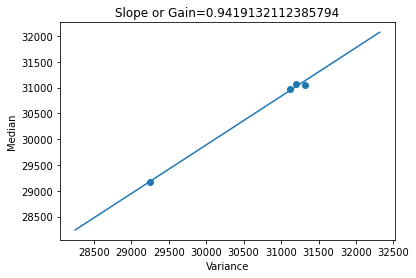

In [ ]:
# Create empty arrays for the variance and median
variance_array = np.array([])
median_array = np.array([])

# Loop over all the files
for i in range(data_cube.shape[2]):

    # Calculate the variance and median
    variance_array = np.append(variance_array, np.var(data_cube[2_000:2_500, 2_000:2_500, i]))
    median_array = np.append(median_array, np.median(data_cube[2_000:2_500, 2_000:2_500, i]))

# Initial guess for the parameters (slope and intercept)
initial_guess = [1, 25_000]

# Perform the optimization using least_squares
result = least_squares(objective, initial_guess, args = (variance_array, median_array))

# Extract the optimized parameters
optimized_params = result.x

# The optimized_params should contain the slope and intercept of the best-fit line
gain, b = optimized_params

# Get jacobian
jacobian = result.jac

# Calculate error on the slope and intercept
error_gain, error_b = np.sqrt(np.diag(np.linalg.inv(jacobian.T.dot(jacobian))))

# Plot the data
plt.scatter(variance_array,median_array)
plt.plot(np.linspace(variance_array.min() - 1000, variance_array.max() + 1_000, 100), 
         gain*np.linspace(variance_array.min() - 1_000, variance_array.max() + 1_000, 100) + b)
plt.xlabel('Variance')
plt.ylabel('Median')
plt.title('Gain = {:.2f} +/- {:.2f}'.format(gain, error_gain))
plt.show()